In [1]:
import cv2
import numpy as np
import sys
import math
import random
from numba import jit
from skimage.feature import peak_local_max
import itertools
from matplotlib import pyplot as plt
import scipy.spatial

# 1 Harris corners

## 1.1

In [2]:
def gradPair(imgA,kernel):
    blurA = cv2.GaussianBlur(imgA,kernel,0)
    gxxA=cv2.Sobel(blurA,cv2.CV_64F,1,0);
    gyyA=cv2.Sobel(blurA,cv2.CV_64F,0,1);
    return gxxA,gyyA

In [3]:
def plotPair(gxx,gyy,title="Title"):
    concat=np.concatenate((gxx,gyy),axis=1)
    plt.imshow(concat,cmap='gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

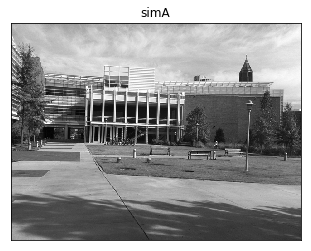

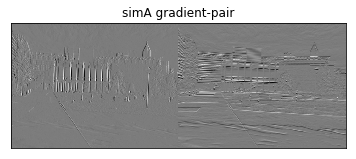

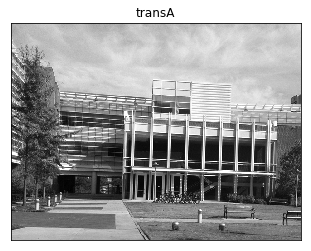

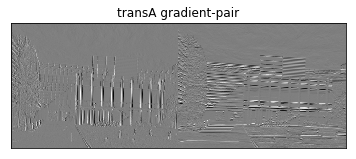

In [4]:
simA = cv2.imread('simA.jpg',0) 
transA = cv2.imread('transA.jpg',0)

#plt.figure(figsize=(20,30))
plt.imshow(simA,cmap='gray')
plt.title('simA'), plt.xticks([]), plt.yticks([])
plt.show()
gxxA, gyyA=gradPair(simA,(3,3));
plotPair(gxxA, gyyA,"simA gradient-pair")

plt.imshow(transA,cmap='gray')
plt.title('transA'), plt.xticks([]), plt.yticks([])
plt.show()
gxxA, gyyA=gradPair(transA,(3,3));
plotPair(gxxA, gyyA,"transA gradient-pair")

## 1.2

In [5]:
@jit
def Harris(gxx,gyy,winSize,sigma=1.4,alpha=1):
    gxx2=gxx*gxx
    gyy2=gyy*gyy
    gxxyy=gxx*gyy
    kernel=cv2.getGaussianKernel(winSize, sigma) 
    kernel=kernel.dot(kernel.T)
    h,w=gxx.shape
    R= np.zeros(shape=(h,w))
    bigI= np.zeros(shape=(h,w),dtype=np.ndarray)
    halfWin=int(winSize/2)
    
    for i in range(halfWin,h-halfWin):
        for j in range(halfWin,w-halfWin):
            I=np.zeros(shape=(2,2))
            I[0,0]=gxx2[i,j]
            I[0,1]=gxxyy[i,j]
            I[1,0]=gxxyy[i,j]
            I[1,1]=gyy2[i,j]
            bigI[i,j]=I
            
    for i in range(halfWin,h-halfWin):
        print(str((i+1-halfWin)*100/(h-halfWin))+"% of an image", end="\r")
        for j in range(halfWin,w-halfWin):
            M= np.zeros(shape=(2,2))
            for iWin in range(-halfWin,halfWin):
                for jWin in range(-halfWin,halfWin):
                    I=bigI[i+iWin,j+jWin]
                    M=M+kernel[halfWin+iWin,halfWin+jWin]*I
            R[i,j]=np.linalg.det(M)-alpha*np.trace(M)**2
    Rnorm=cv2.normalize(R,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return Rnorm

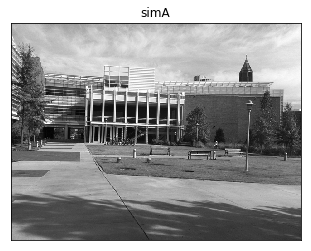

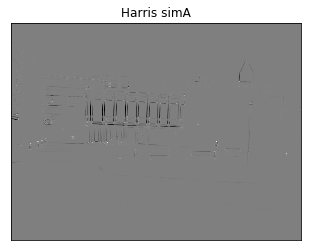

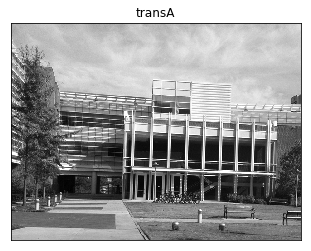

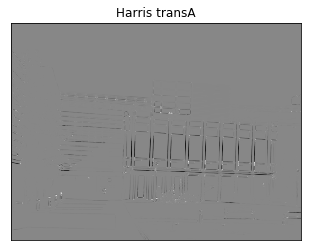

In [6]:
simA = cv2.imread('simA.jpg',0) 
transA = cv2.imread('transA.jpg',0)

#plt.figure(figsize=(20,30))
plt.imshow(simA,cmap='gray')
plt.title('simA'), plt.xticks([]), plt.yticks([])
plt.show()
gxxA, gyyA=gradPair(simA,(3,3));
Rnorm= Harris(gxxA,gyyA,3,1.2,0.04)
plt.imshow(Rnorm,cmap='gray')
plt.title('Harris simA'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(transA,cmap='gray')
plt.title('transA'), plt.xticks([]), plt.yticks([])
plt.show()
gxxA, gyyA=gradPair(transA,(3,3));
Rnorm= Harris(gxxA,gyyA,3,1.2,0.04)
plt.imshow(Rnorm,cmap='gray')
plt.title('Harris transA'), plt.xticks([]), plt.yticks([])
plt.show()

## 1.3

In [7]:
def thresholdAndSupp(R,thr,r):
    '''  thr is a percentage of the max '''
    R=R.copy()
    thrVal=R.max()*thr
    R[R<thrVal]=0
    h,w=R.shape
    Rout= np.zeros(shape=(h,w))
    nnz=(R != 0).sum() 
    #print(nnz)
    while nnz:
        currMax= np.unravel_index(R.argmax(), R.shape)
        xMin=currMax[0]-r
        xMax=currMax[0]+r
        yMin=currMax[1]-r
        yMax=currMax[1]+r
        if (xMin<0):
            xMin=0
        if (yMin<0):
            yMin=0
        if (xMax>h):
            xMax=h
        if (yMax>w):
            yMax=w
        for x in range(xMin, xMax):
            for y in range(yMin, yMax):
                if scipy.spatial.distance.euclidean((currMax[0], currMax[1]), (x, y)) <= r:
                    R[x][y] = 0
        Rout[currMax[0]][currMax[1]] =1
        nnz=(R != 0).sum()
        #print(nnz)
    return Rout


In [8]:
def HarisPipeline(img,kernel=(3,3),winSize=3,sigma=1.4,alpha=0.04,thr=0.54,mindist=10,title="Title"):
    gxx, gyy=gradPair(img,kernel);
    thetas=cv2.phase(gxx,gyy,angleInDegrees=True);
    Rnorm= Harris(gxx,gyy,winSize,sigma,alpha)
    RThr= thresholdAndSupp(Rnorm,thr,mindist)
    xy =RThr.nonzero()
    x= xy[0]
    print("\n There are "+str(len(x))+" points selected")
    y= xy[1]
    plt.figure(figsize=(20,30))
    plt.imshow(img,cmap='gray')
    plt.scatter(y,x)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    return x,y,thetas,xy

99.79123173277662% of an imageee
 There are 248 points selected


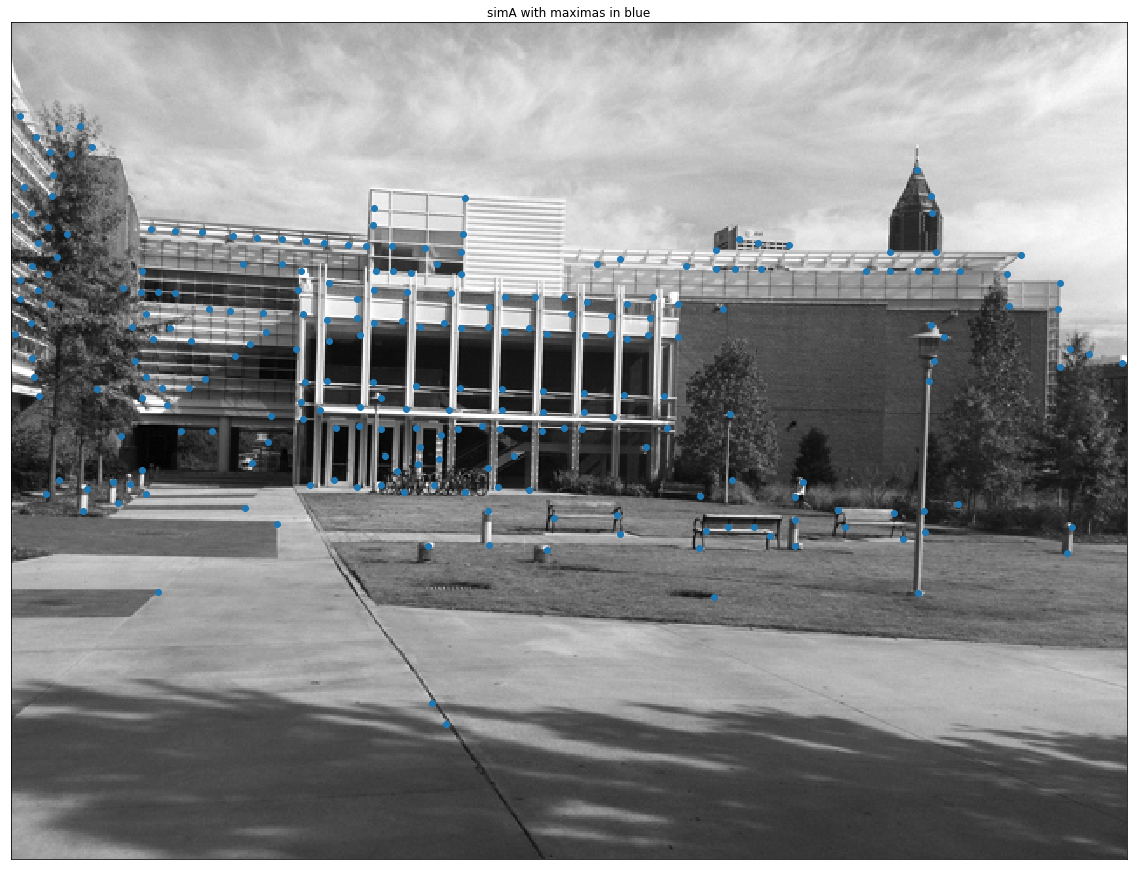

99.79123173277662% of an imageee
 There are 44 points selected


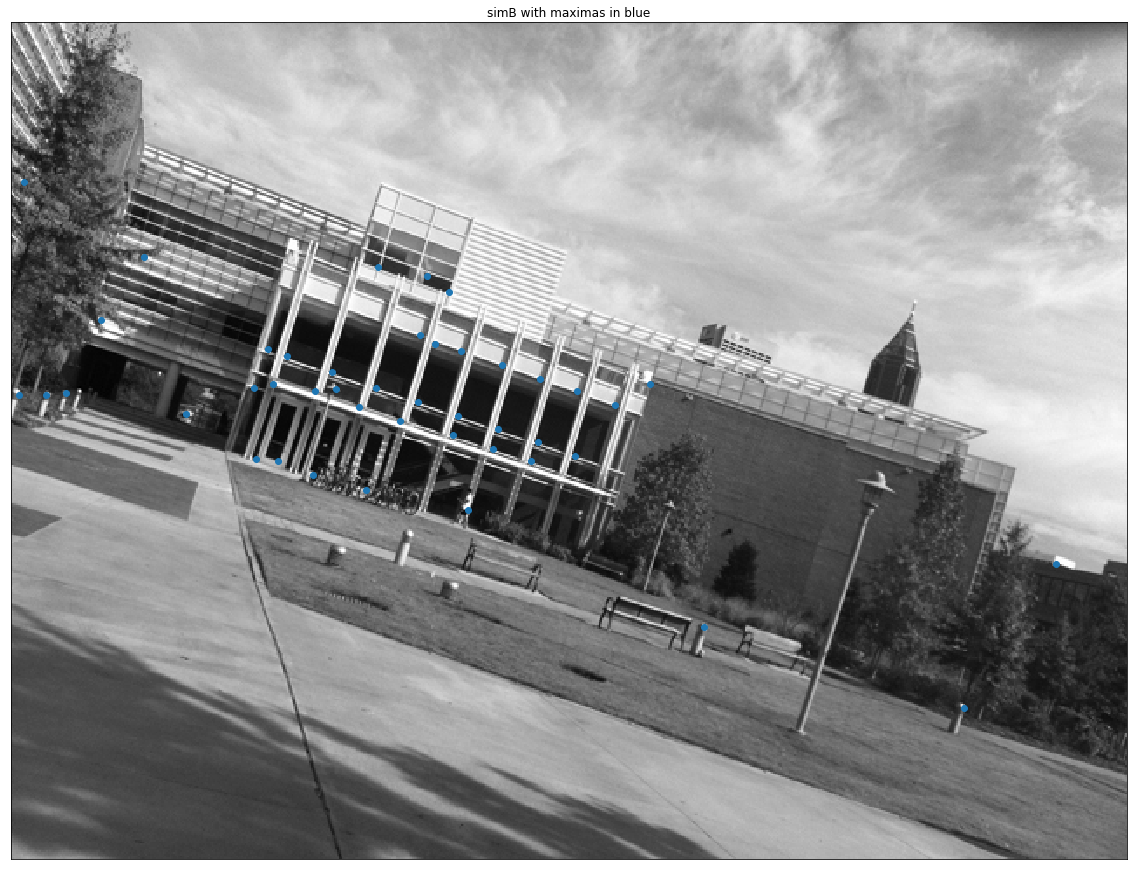

In [9]:
simA = cv2.imread('simA.jpg',0) 
transA = cv2.imread('transA.jpg',0) 
simB = cv2.imread('simB.jpg',0) 
transB = cv2.imread('transB.jpg',0)

xAs,yAs,angleAs,xyAs=HarisPipeline(simA,thr=0.5,mindist=10, title='simA with maximas in blue')
xBs,yBs,angleBs,xyBs=HarisPipeline(simB,thr=0.5,mindist=10, title='simB with maximas in blue')


99.79123173277662% of an imageee
 There are 260 points selected


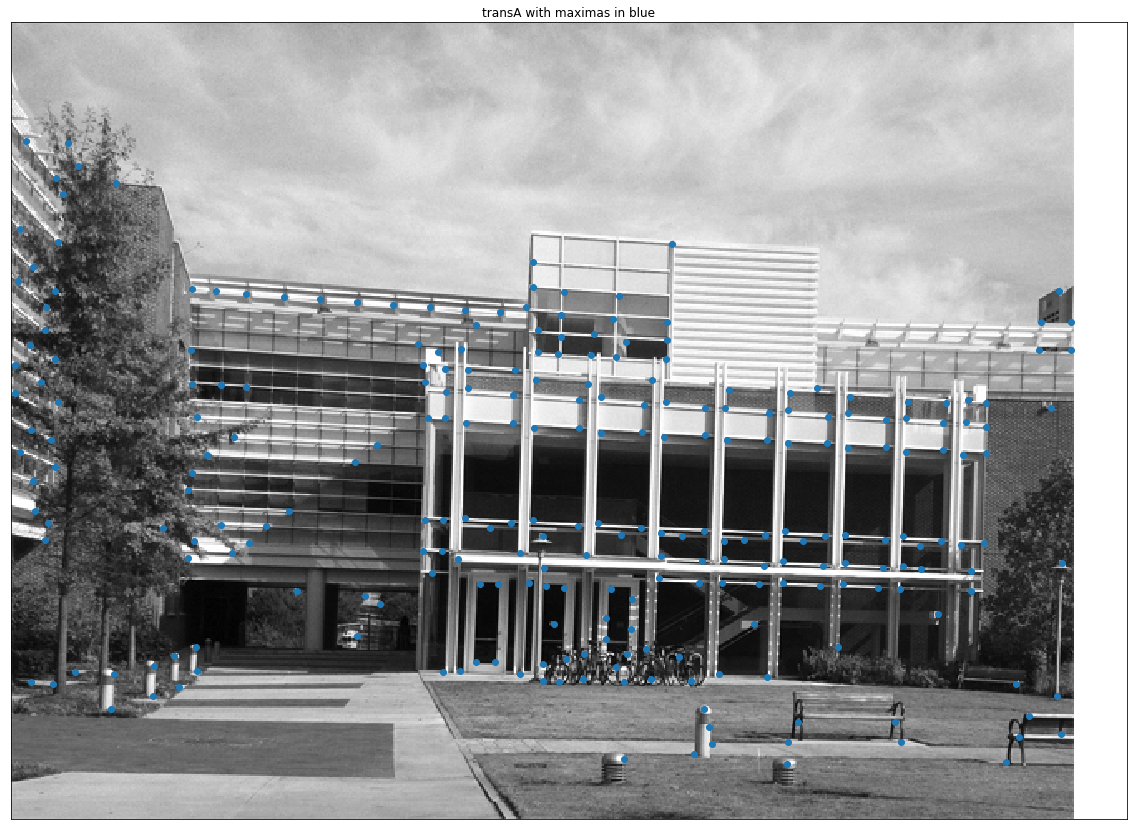

99.79123173277662% of an imageee
 There are 144 points selected


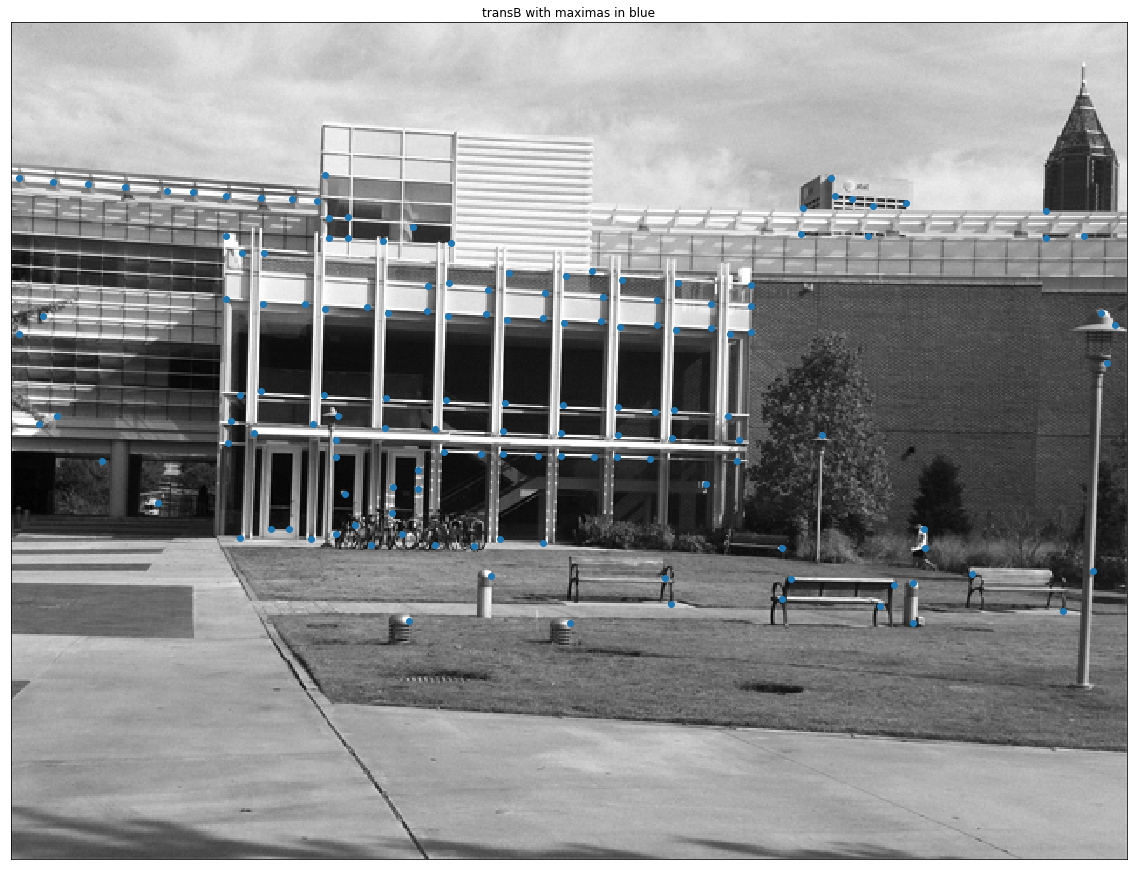

In [10]:
xAt,yAt,angleAt,xyAt=HarisPipeline(transA, title='transA with maximas in blue')
xBt,yBt,angleBt,xyBt=HarisPipeline(transB, title='transB with maximas in blue')

# 2 SIFT features

## 2.1

In [11]:
def plotKeyPoints(x,y,thetas,img,title="Title"):
    kps=[]
    for i in range(0,len(x)):
        kp = cv2.KeyPoint( y[i], x[i],1)
        kp.angle=thetas[ x[i], y[i]]
        kps.append(kp)
    kpimg = cv2.drawKeypoints(img, kps,None)
    plt.figure(figsize=(20,30))
    plt.imshow(kpimg)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    return kps

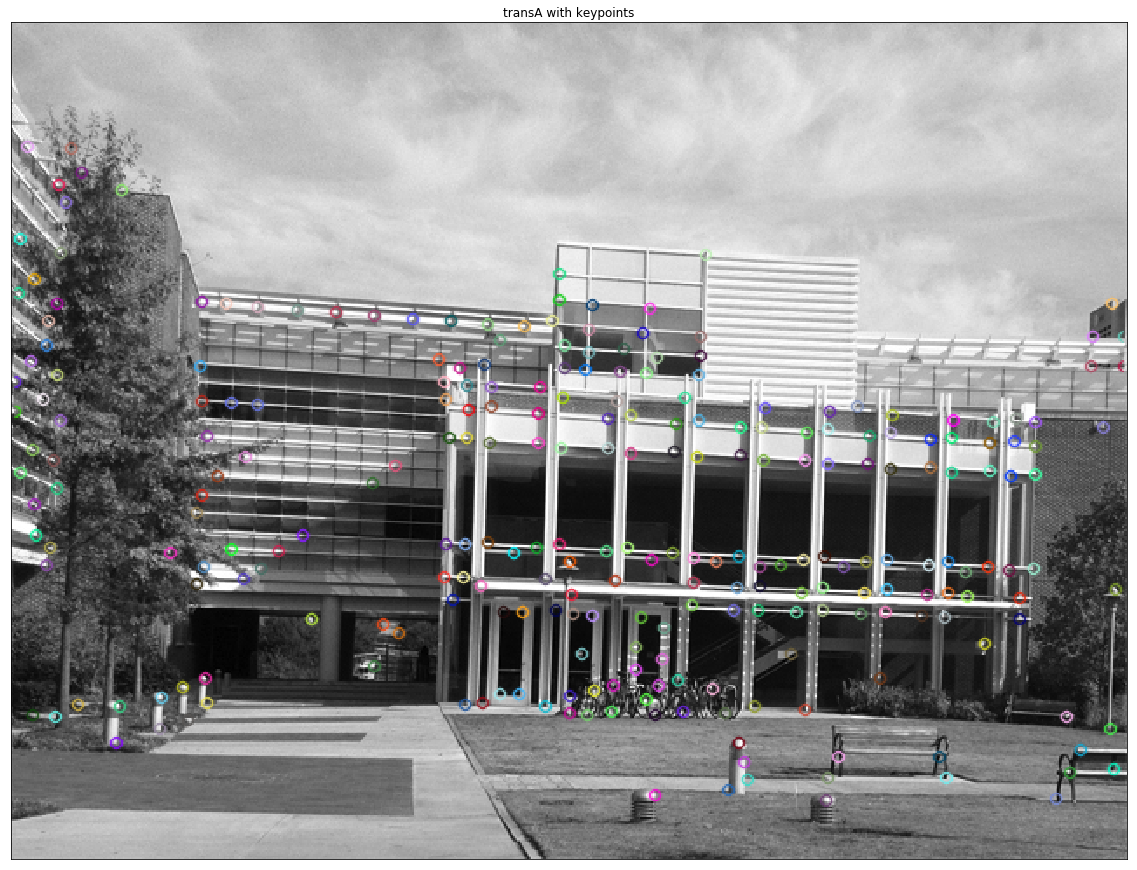

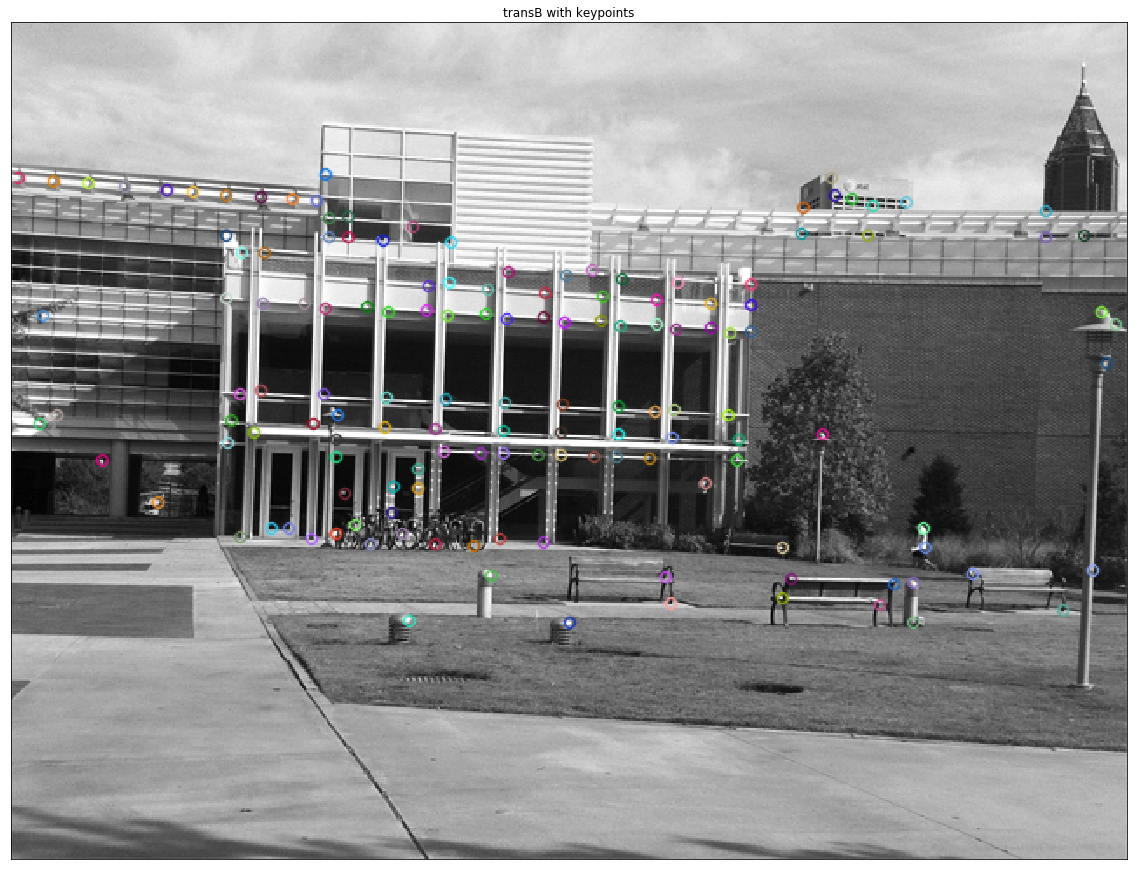

In [12]:
kpsAt=plotKeyPoints(xAt,yAt,angleAt,transA,title='transA with keypoints')
kpsBt=plotKeyPoints(xBt,yBt,angleBt,transB,title='transB with keypoints')

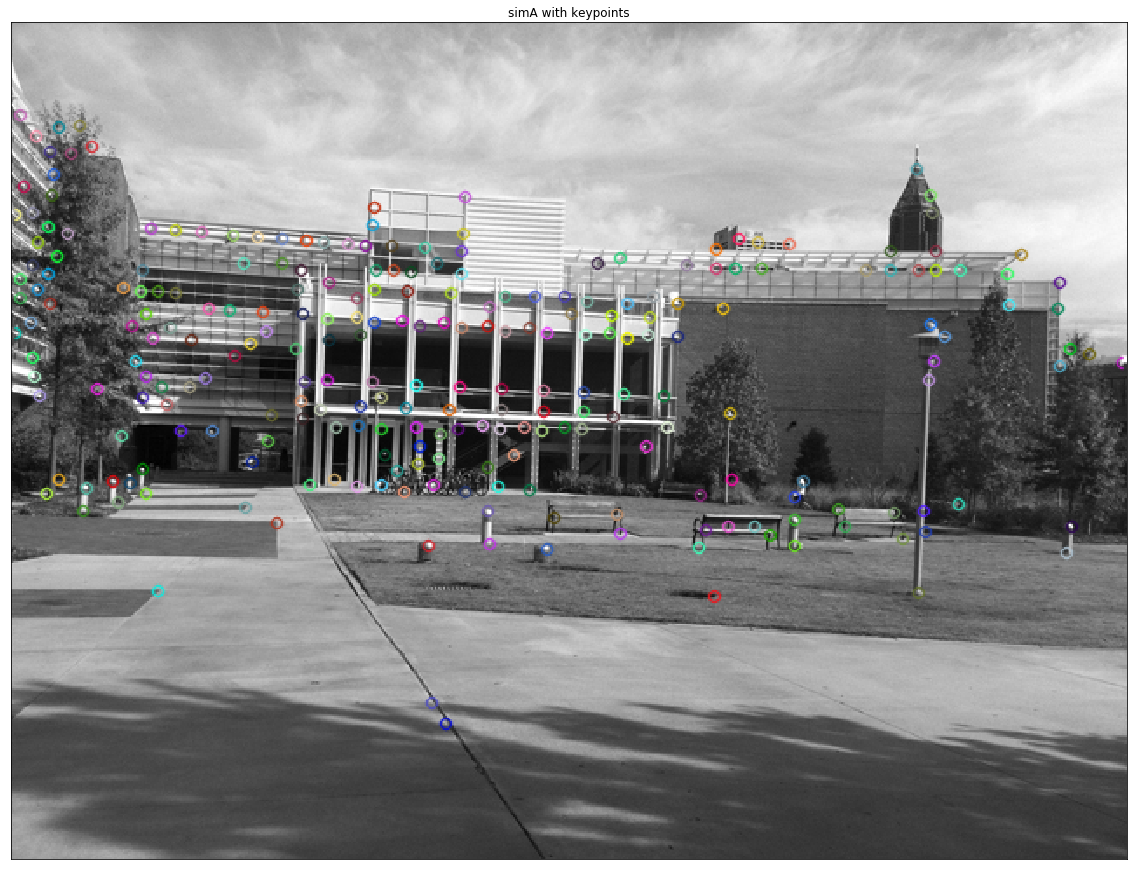

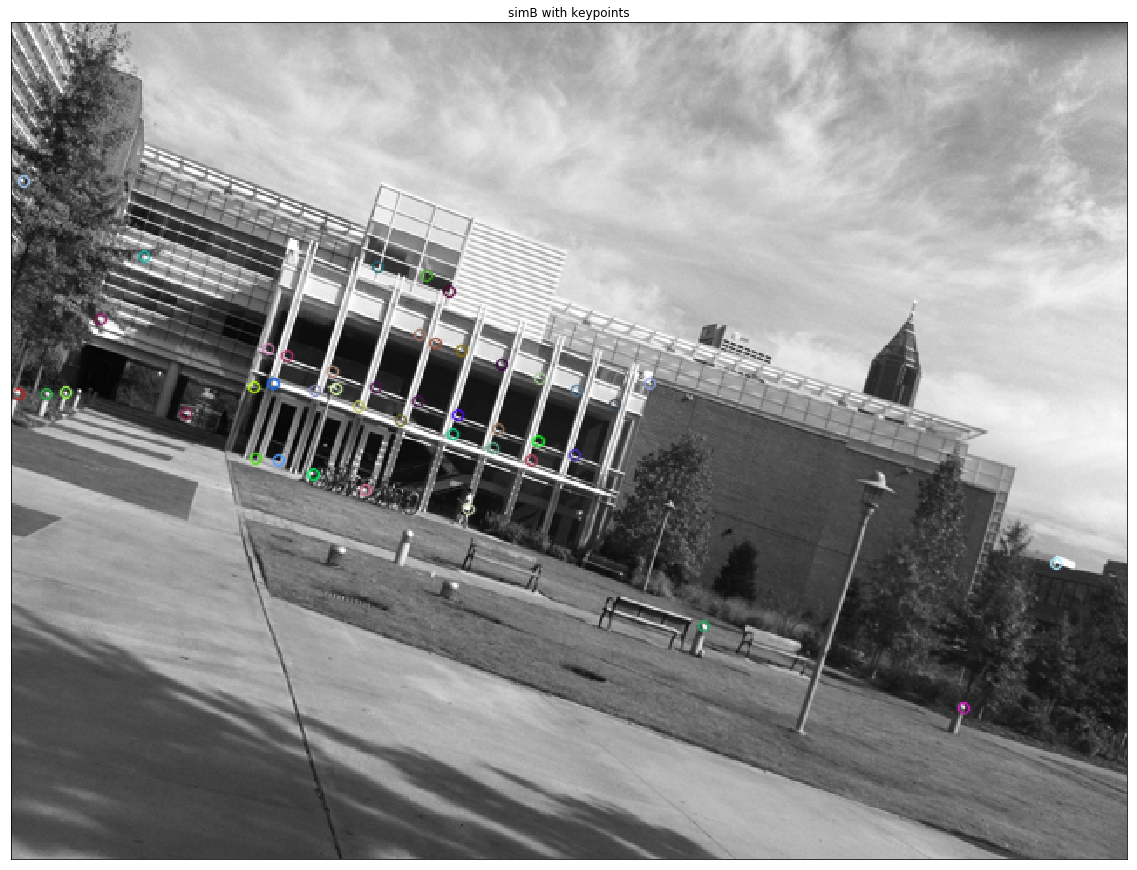

In [13]:
kpsAs=plotKeyPoints(xAs,yAs,angleAs,simA,title='simA with keypoints')
kpsBs=plotKeyPoints(xBs,yBs,angleBs,simB,title='simB with keypoints')

## 2.2

In [14]:
sift = cv2.xfeatures2d.SIFT_create()
_ , desAs = sift.compute(simA,kpsAs)
_ , desBs = sift.compute(simB,kpsBs)
_ , desAt = sift.compute(transA,kpsAt)
_ , desBt = sift.compute(transB,kpsBt)

In [15]:
def matchAndPlot(imgA,imgB,desAt,desBt,keyPtsA,keyPtsB,title="Title",nbLines=30):
    bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
    matchAll = bf.match(desAt,desBt)
    matches=matchAll[:nbLines]
    concat=np.concatenate((imgA,imgB),axis=1)
    concat=cv2.cvtColor( concat, cv2.COLOR_GRAY2RGB); 
    plt.figure(figsize=(20,60))
    h,w=imgA.shape
    for match in matches:
        xyA=keyPtsA[match.queryIdx].pt
        xyA= int(xyA[0]), int(xyA[1])
        xyB=keyPtsB[match.trainIdx].pt
        xyB= int(xyB[0]+w), int(xyB[1])
        cv2.line(concat,xyA,xyB, (0,255,0),1)
    plt.imshow(concat)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    return matchAll

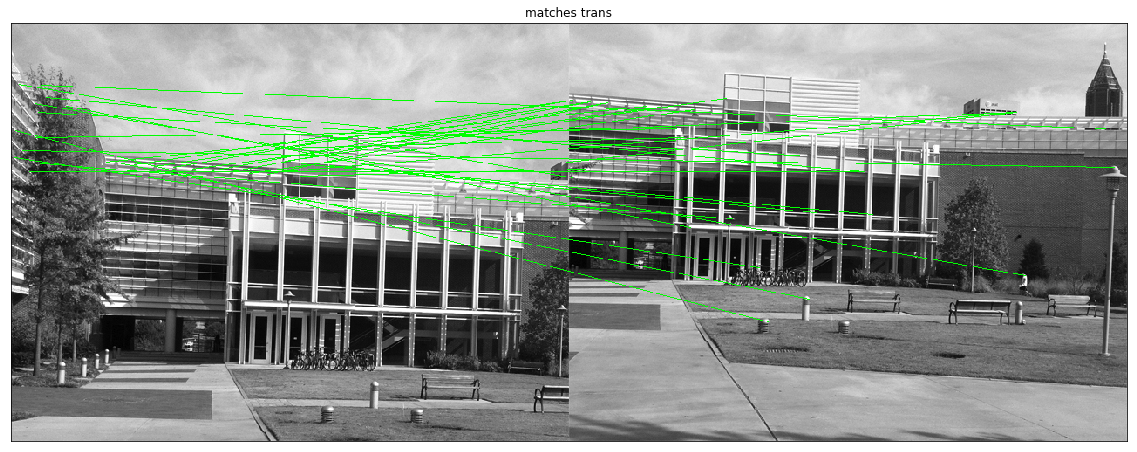

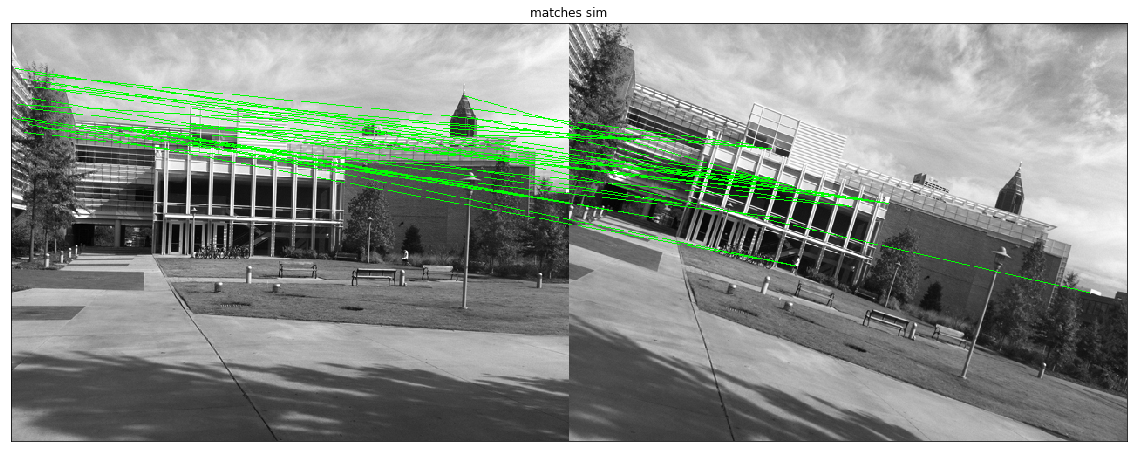

In [16]:
matchesT=matchAndPlot(transA,transB,desAt,desBt,kpsAt,kpsBt,title='matches trans')
matchesS=matchAndPlot(simA,simB,desAs,desBs,kpsAs,kpsBs,title='matches sim')

# 3 - RANSAC

## 3.1

In [17]:
def find_intercept_point(m, c, xy):
    x = (xy[0] + m*xy[1] - m*c)/(1 + m**2)
    y = (m*xy[0] + (m**2)*xy[1] - (m**2)*c)/(1 + m**2) + c
 
    return x, y

In [18]:

def ransacLin(imgA,imgB,matches,keyPtsA,keyPtsB,ransac_iterations=5000,ransac_threshold=0.05,ratio=0.01,verbose=False):
    bestMatch=None
    match_listBest=[]
    h,w=imgA.shape
    for i in range(0,ransac_iterations):
        currMatch= np.random.randint(0,len(matches))
        remaining = matches.copy()
        remaining.pop(currMatch)
        
        currMatch=matches[currMatch]
        distChoosen=currMatch.distance
        xyA=keyPtsA[currMatch.queryIdx].pt
        xyA= int(xyA[0]), int(xyA[1])
        xyB=keyPtsB[currMatch.trainIdx].pt
        xyB= int(xyB[0]+w), int(xyB[1])
        m = (xyB[1] - xyA[1]) / (xyB[0] - xyA[0])  # slope of the line
        match_list = []
        num = 0    
        for match in remaining:
            xyA=keyPtsA[match.queryIdx].pt
            xyA= int(xyA[0]), int(xyA[1])
            xyB=keyPtsB[match.trainIdx].pt
            xyB= int(xyB[0]+w), int(xyB[1])
            
            mCurr = (xyB[1] - xyA[1]) / (xyB[0] - xyA[0])  # slope of the line
            
            distCurr=match.distance
            
            dist = np.sqrt((m-mCurr)**2+((distChoosen-distCurr)/(w))**2)
            if verbose:
                print("m = "+str(m)+" mCurr= "+str(mCurr)+" distCh = "+str(distChoosen)+" distCurr= "+str(distCurr) +" dist="+str(dist))
            
            if dist < ransac_threshold:
                match_list.append(match)
                num += 1
        if num/float(len(remaining)) > ratio:
            ratio = num/float(len(remaining))
            match_listBest=match_list
    print ('  inlier ratio = '+str(ratio))
    print(m)
    return match_listBest

In [19]:
matchesBest=ransacLin(transA,transB,matchesT,kpsAt,kpsBt)

  inlier ratio = 0.03088803088803089
-0.2753623188405797


In [20]:
def plotMatches(imgA,imgB,keyPtsA,keyPtsB,matches,title="Title"):
    concat=np.concatenate((imgA,imgB),axis=1)
    concat=cv2.cvtColor( concat, cv2.COLOR_GRAY2RGB); 
    plt.figure(figsize=(20,60))
    h,w=imgA.shape
    for match in matches:
        xyA=keyPtsA[match.queryIdx].pt
        xyA= int(xyA[0]), int(xyA[1])
        xyB=keyPtsB[match.trainIdx].pt
        xyB= int(xyB[0]+w), int(xyB[1])
        cv2.line(concat,xyA,xyB, (0,255,0),1)
        
    plt.imshow(concat)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

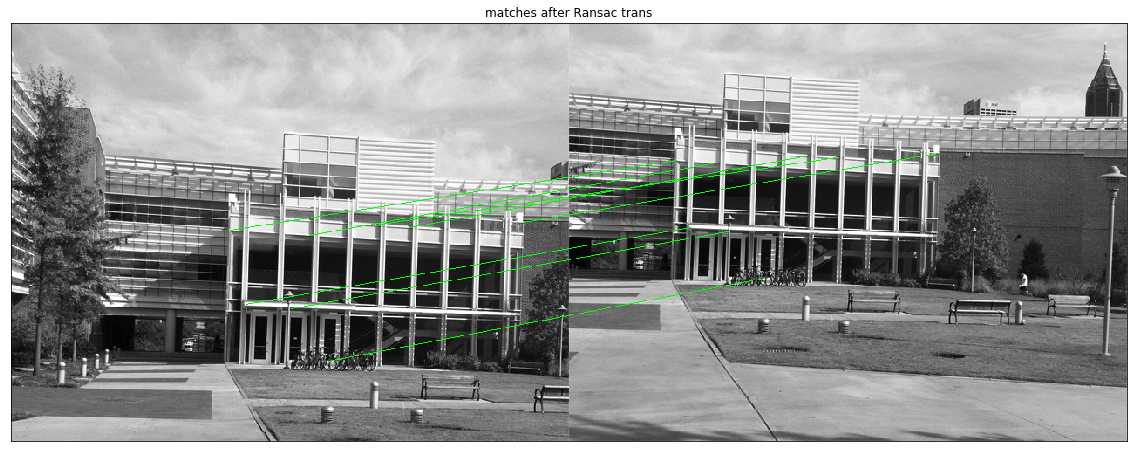

In [21]:
plotMatches(transA,transB,kpsAt,kpsBt,matchesBest,title='matches after Ransac trans')

## 3 -2

In [22]:
def findSim(currMatch,keyPtsA,keyPtsB,w):
    UVA=keyPtsA[currMatch[0].queryIdx].pt
    UVA= int(UVA[0]), int(UVA[1])
    UVB=keyPtsA[currMatch[1].queryIdx].pt
    UVB= int(UVB[0]), int(UVB[1])
        
    UVA_=keyPtsB[currMatch[0].trainIdx].pt
    UVA_= int(UVA_[0]+w), int(UVA_[1])
    UVB_=keyPtsB[currMatch[1].trainIdx].pt
    UVB_= int(UVB_[0]+w), int(UVB_[1])
        
  
    a=np.array([[UVA[0],-UVA[1],1,0],[UVA[1],UVA[0],0,1],[UVB[0],-UVB[1],1,0],[UVB[1],UVB[0],0,1]])
    b=np.array([UVA_[0],UVA_[1],UVB_[0],UVB_[1]])
    m=np.linalg.solve(a,b)
    m=np.array([[m[0],-m[1],m[2]],[m[1],m[0],m[3]]])
    return m

In [23]:
def findDistSim(match,keyPtsA,keyPtsB,w,mGlobal):
    UV=keyPtsA[match.queryIdx].pt
    UV= int(UV[0]), int(UV[1])        
    UV_=keyPtsB[match.trainIdx].pt
    UV_= int(UV_[0]+w), int(UV_[1])
    UV_pred=mGlobal.dot([UV[0],UV[1],1]) 
    #print(UV_)
    #print(UV_pred)
    return np.linalg.norm(UV_-UV_pred)

In [24]:

def ransacSim(imgA,imgB,matches,keyPtsA,keyPtsB,ransac_iterations=5000,ransac_threshold=3,ratio=0.001,verbose=False):
    bestMatch=None
    match_listBest=[]
    h,w=imgA.shape
    for i in range(0,ransac_iterations):
        currMatchId= np.random.randint(0,len(matches)-1,2)
        
        departure1=keyPtsA[matches[currMatchId[1]].queryIdx].pt
        arrival1=keyPtsB[matches[currMatchId[1]].trainIdx].pt
        
        departure0=keyPtsA[matches[currMatchId[0]].queryIdx].pt
        arrival0=keyPtsB[matches[currMatchId[0]].trainIdx].pt
        
        
        while departure1==departure0 or arrival1==arrival0:
            currMatchId= np.random.randint(0,len(matches)-1,2)

            departure1=keyPtsA[matches[currMatchId[1]].queryIdx].pt
            arrival1=keyPtsB[matches[currMatchId[1]].trainIdx].pt

            departure0=keyPtsA[matches[currMatchId[0]].queryIdx].pt
            arrival0=keyPtsB[matches[currMatchId[0]].trainIdx].pt
            
            
        remaining = matches.copy()
        
        remaining.pop(currMatchId[0])
        remaining.pop(currMatchId[1])  
        currMatch=[matches[currMatchId[0]],matches[currMatchId[1]]]
        
        m = findSim(currMatch,keyPtsA,keyPtsB,w)
        
        if verbose:
            distToSelf0=findDistSim(currMatch[0],keyPtsA,keyPtsB,w,m)
            distToSelf1=findDistSim(currMatch[1],keyPtsA,keyPtsB,w,m)

            print("dist to self: " + str(distToSelf0) + "and " +str(distToSelf1))
        match_list = []
        num = 0    
        
        for match in remaining:
            
            dist =  findDistSim(match,keyPtsA,keyPtsB,w,m)

            if verbose:
                print(" dist="+str(dist))
            
            if dist < ransac_threshold:
               
                match_list.append(match)
                num += 1
        if num/float(len(remaining)) > ratio:
            ratio = num/float(len(remaining))
            match_listBest=match_list
    print ('  inlier ratio = '+str(ratio))
    print(m)
    return match_listBest

In [25]:
matchesBest=ransacSim(simA,simB,matchesS,kpsAs,kpsBs)

  inlier ratio = 0.052845528455284556
[[  1.15498667e-01   1.89932810e-02   6.10954506e+02]
 [ -1.89932810e-02   1.15498667e-01   1.88778687e+02]]


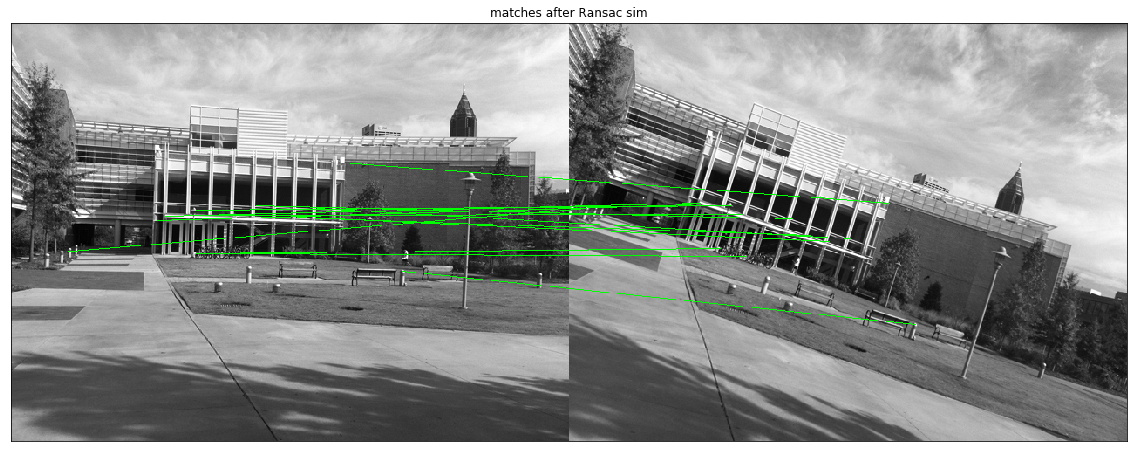

In [26]:
plotMatches(simA,simB,kpsAs,kpsBs,matchesBest,title='matches after Ransac sim')